# Importing the relevant libraries

In [1]:
# %pip install statsmodels

In [62]:
#  Load the data from the ml_datasource.csv file into a pandas DataFrame and examine the dataset.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier


# Data Preprocessing

### Importing the Database

In [3]:
raw_data = pd.read_csv("ml_datasource.csv")
raw_data.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0


In [4]:
data = raw_data.copy()

### Removing Outliers

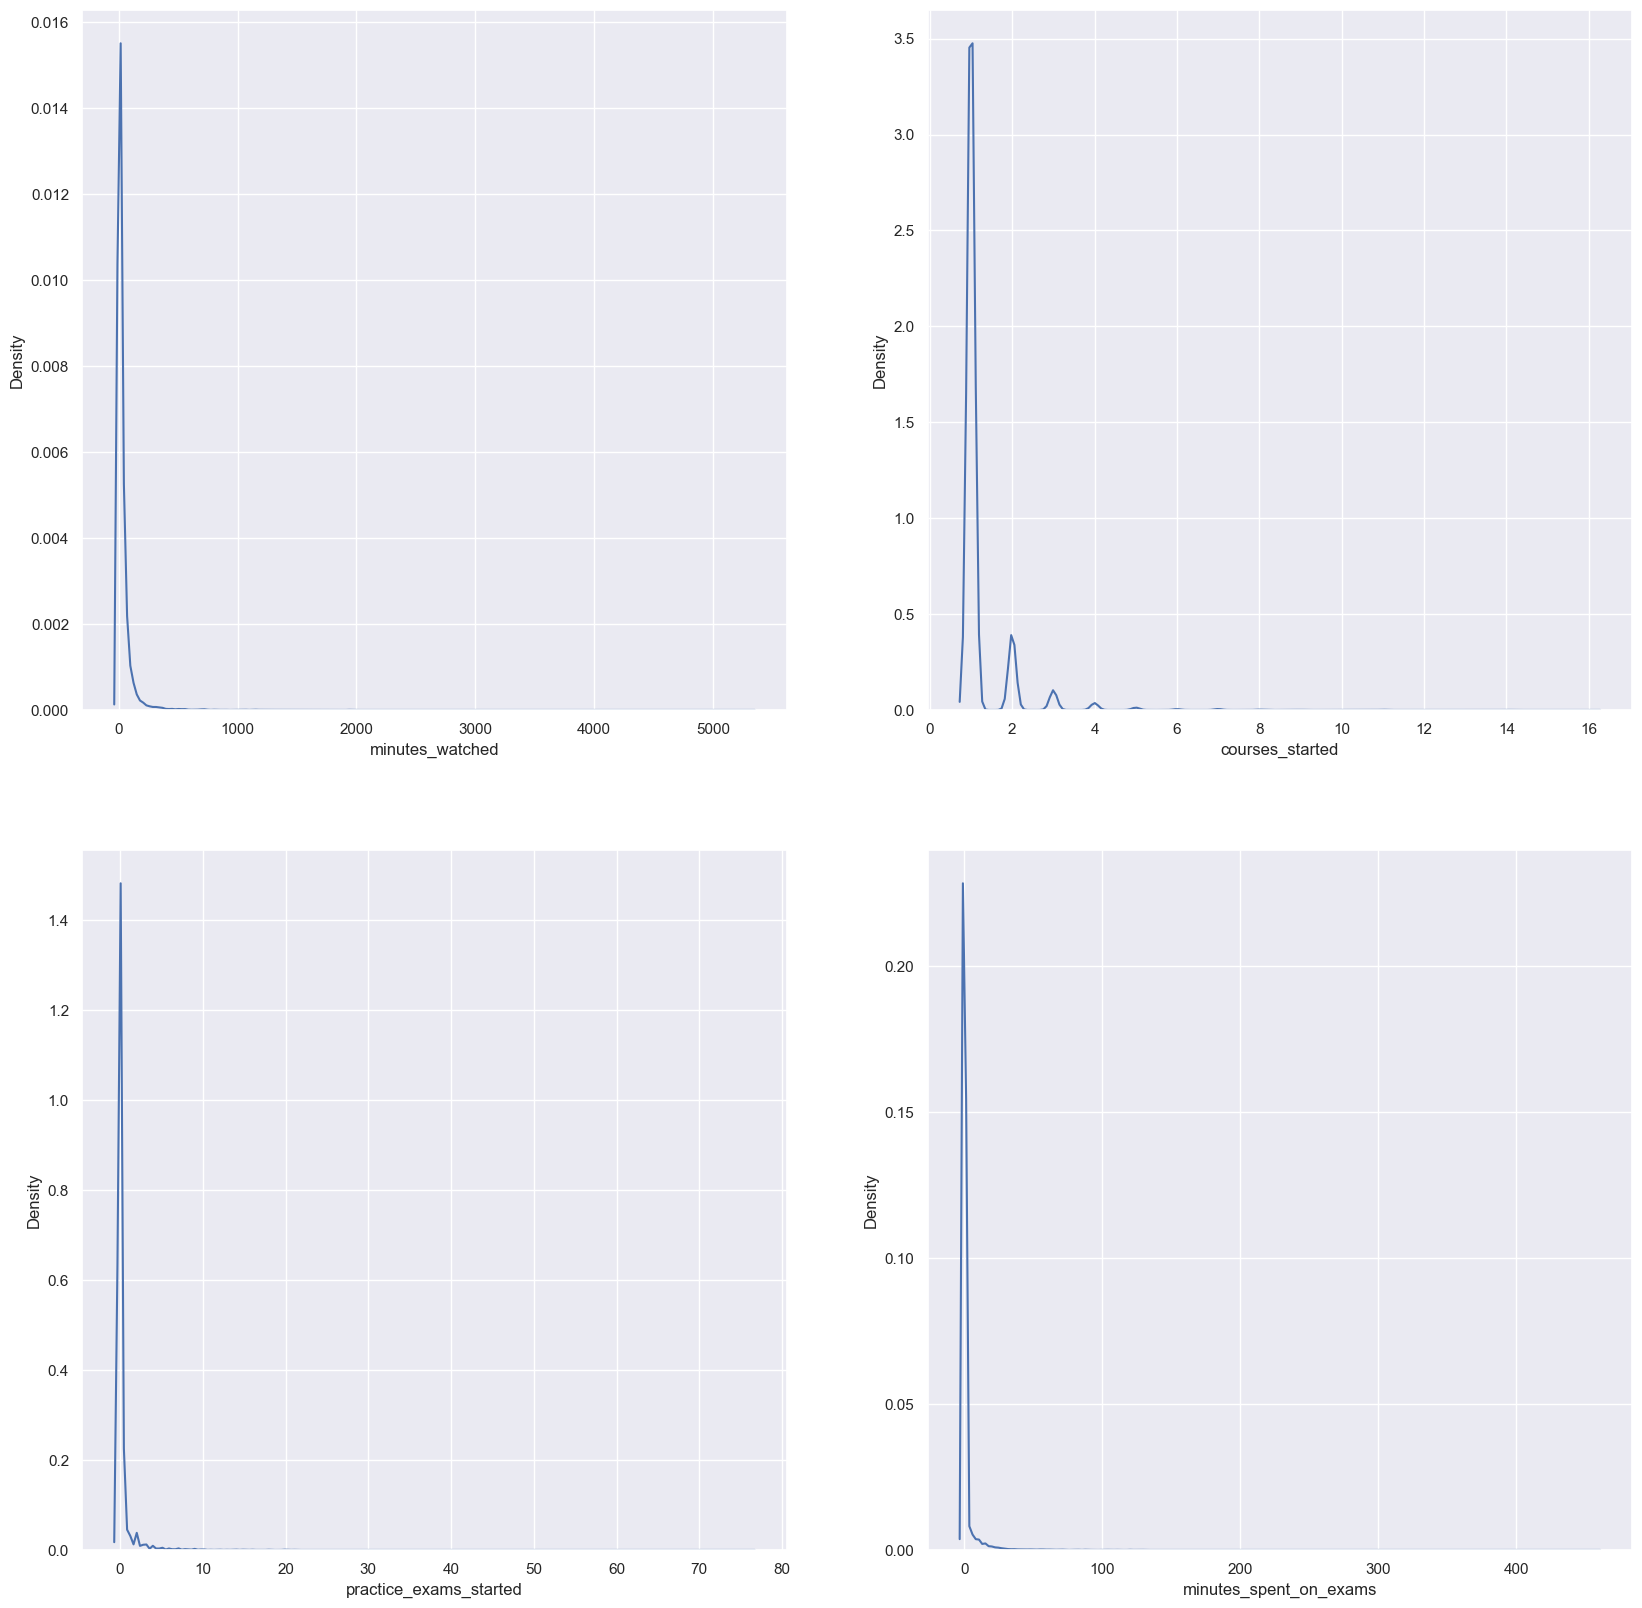

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(20,20))
sns.kdeplot(data['minutes_watched'], ax=axes[0, 0])
sns.kdeplot(data['courses_started'], ax=axes[0, 1])
sns.kdeplot(data['practice_exams_started'], ax=axes[1, 0])
sns.kdeplot(data['minutes_spent_on_exams'], ax=axes[1, 1])
plt.show()


In [6]:
data_no_outliers = data[(data['minutes_watched'] <= 1000) & 
                         (data['courses_started'] <= 10) & 
                         (data['practice_exams_started'] <= 10) & 
                         (data['minutes_spent_on_exams'] <= 40)]

In [7]:
data_no_outliers.describe()

,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
count,17626.000000,17626.000000,17626.000000,17626.000000,17626.000000,17626.000000,17626.000000
mean,123.454102,27.145342,1.177295,0.183195,0.119029,0.778405,0.092137
std,90.773394,56.290650,0.559075,0.817034,0.588701,3.476651,0.289227
min,0.000000,0.100000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,41.000000,1.100000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,113.000000,6.700000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,204.000000,33.400000,1.000000,0.000000,0.000000,0.000000,0.000000
max,292.000000,994.200000,9.000000,10.000000,9.000000,40.000000,1.000000


In [8]:
data_no_outliers.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0


### Checking for Multicollinearity

In [9]:
# display the data_no_outliers columns
data_no_outliers.columns

Index(['student_country', 'days_on_platform', 'minutes_watched',
       'courses_started', 'practice_exams_started', 'practice_exams_passed',
       'minutes_spent_on_exams', 'purchased'],
      dtype='object')

In [10]:
# Calculate the VIF for each feature:
# drop the purchased and student_country variable
X = data_no_outliers.drop(['purchased', 'student_country'], axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,feature,VIF
0,days_on_platform,2.301237
1,minutes_watched,1.788777
2,courses_started,3.178713
3,practice_exams_started,10.201823
4,practice_exams_passed,7.812546
5,minutes_spent_on_exams,3.345478


In [11]:
# Remove the feature that have VIF with value above 5
# Filter out features with VIF greater than 5
high_vif = vif_data[vif_data["VIF"] > 5]

# Print the features with high VIF
high_vif

,feature,VIF
3,practice_exams_started,10.201823
4,practice_exams_passed,7.812546


In [12]:
# Drop the specified columns from the DataFrame
data_no_mult = data.drop(columns=['practice_exams_started', 'practice_exams_passed'])

# Verify that the columns are dropped
data_no_mult.head()


,student_country,days_on_platform,minutes_watched,courses_started,minutes_spent_on_exams,purchased
0,US,288,358.1,1,15.81,0
1,SG,260,1.7,1,16.00,0
2,TR,260,22.4,1,0.93,0
3,KE,259,18.8,1,14.63,0
4,IN,259,118.0,2,16.48,0


### Dealing with NaN Values

In [13]:
# check if the columns has Na/Nan values
data_no_mult.isna().sum()

student_country           9
days_on_platform          0
minutes_watched           0
courses_started           0
minutes_spent_on_exams    0
purchased                 0
dtype: int64

In [14]:
data_no_nulls = data_no_mult.fillna({'student_country': 'NAM'})
data_no_nulls

,student_country,days_on_platform,minutes_watched,courses_started,minutes_spent_on_exams,purchased
0,US,288,358.1,1,15.81,0
1,SG,260,1.7,1,16.00,0
2,TR,260,22.4,1,0.93,0
3,KE,259,18.8,1,14.63,0
4,IN,259,118.0,2,16.48,0
...,...,...,...,...,...,...
17756,EG,0,0.8,1,0.00,0
17757,IN,0,0.1,1,0.00,0
17758,CM,0,7.8,1,0.00,0
17759,CA,0,10.4,1,0.00,0


### Splitting the Data

In [15]:
X = data_no_nulls.drop(columns=['purchased'])
y = data_no_nulls['purchased']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=365, stratify=y)


### Encoding the Data

In [17]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=170)

In [18]:
X_train['student_country_enc'] = enc.fit_transform(X_train[['student_country']])
X_test['student_country_enc'] = enc.transform(X_test[['student_country']])

In [19]:
X_train = X_train.drop(columns=['student_country'])
X_test = X_test.drop(columns=['student_country'])

In [20]:
X_train_array = np.asarray(X_train, dtype='float')
y_train_array = np.asarray(y_train, dtype='int')
X_test_array = np.asarray(X_test, dtype='float')
y_test_array = np.asarray(y_test, dtype='int')

# Creating a Logistic Regression Model

In [21]:
# Set up the logistic regression model
log_reg = sm.Logit(y_train_array, sm.add_constant(X_train_array))

In [22]:
# Fit the model
log_reg_results = log_reg.fit()

Optimization terminated successfully.
         Current function value: 0.157807
         Iterations 10


In [23]:
# Display the model summary
print(log_reg_results.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                14208
Model:                          Logit   Df Residuals:                    14202
Method:                           MLE   Df Model:                            5
Date:                Mon, 11 Nov 2024   Pseudo R-squ.:                  0.4856
Time:                        10:38:49   Log-Likelihood:                -2242.1
converged:                       True   LL-Null:                       -4359.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0235      0.113     -9.061      0.000      -1.245      -0.802
x1            -0.0632      0.002    -30.822      0.000      -0.067      -0.059
x2             0.0075      0.001     12.588      0.0

In [24]:
# Predict the probabilities of the test data
y_pred_prob = log_reg_results.predict(sm.add_constant(X_test_array))

In [25]:
# Convert predicted probabilities to binary predictions
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

# Confusion Matrix Overview

The confusion matrix provides a 2x2 matrix with the following classifications:

## True Positives (TP)
Correctly predicted students who purchased a subscription.

## True Negatives (TN)
Correctly predicted students who did not purchase a subscription.

## False Positives (FP)
Incorrectly predicted students who were predicted to buy but did not.

## False Negatives (FN)
Incorrectly predicted students who were predicted not to buy but actually purchased.


In [26]:
# Generate confusion matrix
cm = confusion_matrix(y_test_array, y_pred)
cm

array([[3199,   28],
       [ 134,  192]], dtype=int64)

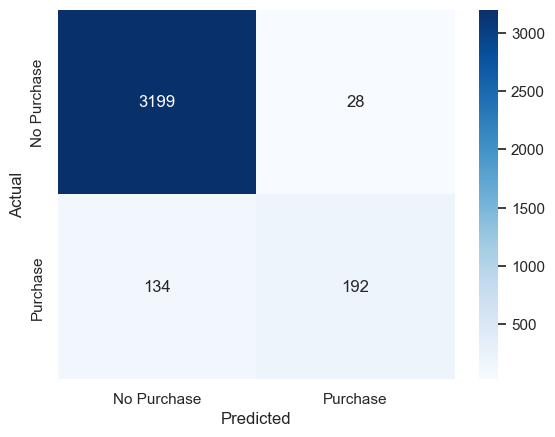

In [27]:
# Create a heatmap for the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Purchase", "Purchase"], yticklabels=["No Purchase", "Purchase"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Creating a K-Nearest Neighbors Model

In [28]:
# Define parameter grid
parameters_knn = {
    'n_neighbors': range(1, 51),    # Range for number of neighbors (1 to 50)
    'weights': ['uniform', 'distance']  # Weighting options
}

In [29]:
# Initialize KNN classifier
knn = KNeighborsClassifier()

# Set up GridSearchCV
grid_search_knn = GridSearchCV(estimator=knn, param_grid=parameters_knn, scoring='accuracy', cv=5)

In [30]:
# Fit grid search to training data
grid_search_knn.fit(X_train_array, y_train_array)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 51),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [31]:
# Get the best KNN model
knn_clf = grid_search_knn.best_estimator_
print("Best parameters found:", grid_search_knn.best_params_)
print("Best cross-validated accuracy:", grid_search_knn.best_score_)

Best parameters found: {'n_neighbors': 5, 'weights': 'uniform'}
Best cross-validated accuracy: 0.9591783725834215


In [32]:
knn_clf

KNeighborsClassifier()

In [33]:
# Predict on test data
y_test_pred_knn = knn_clf.predict(X_test_array)
y_test_pred_knn

array([0, 0, 0, ..., 0, 0, 0])

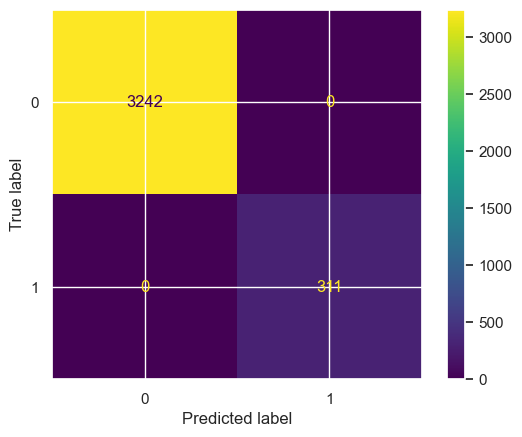

In [61]:
# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(knn_clf, X_test_array, y_test_pred_knn)

In [35]:
# Print classification report
print(classification_report(y_test_array, y_test_pred_knn, target_names=['No Purchase', 'Purchase']))


              precision    recall  f1-score   support

 No Purchase       0.98      0.98      0.98      3227
    Purchase       0.81      0.77      0.79       326

    accuracy                           0.96      3553
   macro avg       0.89      0.88      0.89      3553
weighted avg       0.96      0.96      0.96      3553



# Creating a Support Vector Machines Model

In [39]:
# Initialize MinMaxScaler with the range -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train_array)

# Transform test data using the same scaler
X_test_scaled = scaler.transform(X_test_array)

In [40]:
# Define parameter grid for SVM
parameters_svm = {
    'kernel': ['linear', 'poly', 'rbf'],   # Kernels to consider
    'C': range(1, 11),                     # Regularization parameter C (1 to 10)
    'gamma': ['scale', 'auto']             # Kernel coefficient gamma
}

In [41]:
# Initialize SVM classifier
svm = SVC()

# Set up GridSearchCV with SVM model
grid_search_svm = GridSearchCV(estimator=svm, param_grid=parameters_svm, scoring='accuracy', cv=5)

In [42]:
# Fit the grid search on scaled training data
grid_search_svm.fit(X_train_scaled, y_train_array)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': range(1, 11), 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='accuracy')

In [43]:
# Get the best SVM model
svm_clf = grid_search_svm.best_estimator_
print("Best parameters found:", grid_search_svm.best_params_)
print("Best cross-validated accuracy:", grid_search_svm.best_score_)

Best parameters found: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
Best cross-validated accuracy: 0.9584746180451571


In [44]:
# Predict on scaled test data
y_test_pred_svm = svm_clf.predict(X_test_scaled)

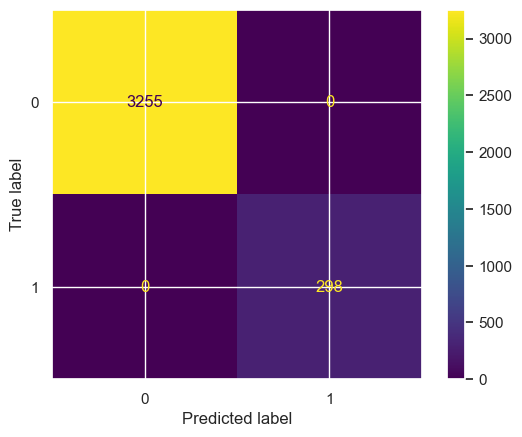

In [60]:
# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(svm_clf, X_test_scaled, y_test_pred_svm)


In [46]:
# Print classification report
print(classification_report(y_test_array, y_test_pred_svm, target_names=['No Purchase', 'Purchase']))

              precision    recall  f1-score   support

 No Purchase       0.98      0.98      0.98      3227
    Purchase       0.82      0.75      0.79       326

    accuracy                           0.96      3553
   macro avg       0.90      0.87      0.88      3553
weighted avg       0.96      0.96      0.96      3553



# Creating a Decision Trees Model

In [48]:
# Define parameter grid for ccp_alpha
parameters_tree = {
    'ccp_alpha': [0, 0.001, 0.002, 0.003, 0.004, 0.005]  # Regularization parameter
}

In [49]:
# Initialize Decision Tree classifier with a fixed random state
tree = DecisionTreeClassifier(random_state=365)

In [50]:
# Set up GridSearchCV with Decision Tree classifier
grid_search_tree = GridSearchCV(estimator=tree, param_grid=parameters_tree, scoring='accuracy', cv=5)
# Fit the grid search on the training data
grid_search_tree.fit(X_train_array, y_train_array)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=365),
             param_grid={'ccp_alpha': [0, 0.001, 0.002, 0.003, 0.004, 0.005]},
             scoring='accuracy')

In [51]:
# Get the best Decision Tree model
best_tree = grid_search_tree.best_estimator_
print("Best parameters found:", grid_search_tree.best_params_)
print("Best cross-validated accuracy:", grid_search_tree.best_score_)

Best parameters found: {'ccp_alpha': 0.003}
Best cross-validated accuracy: 0.961008193832097


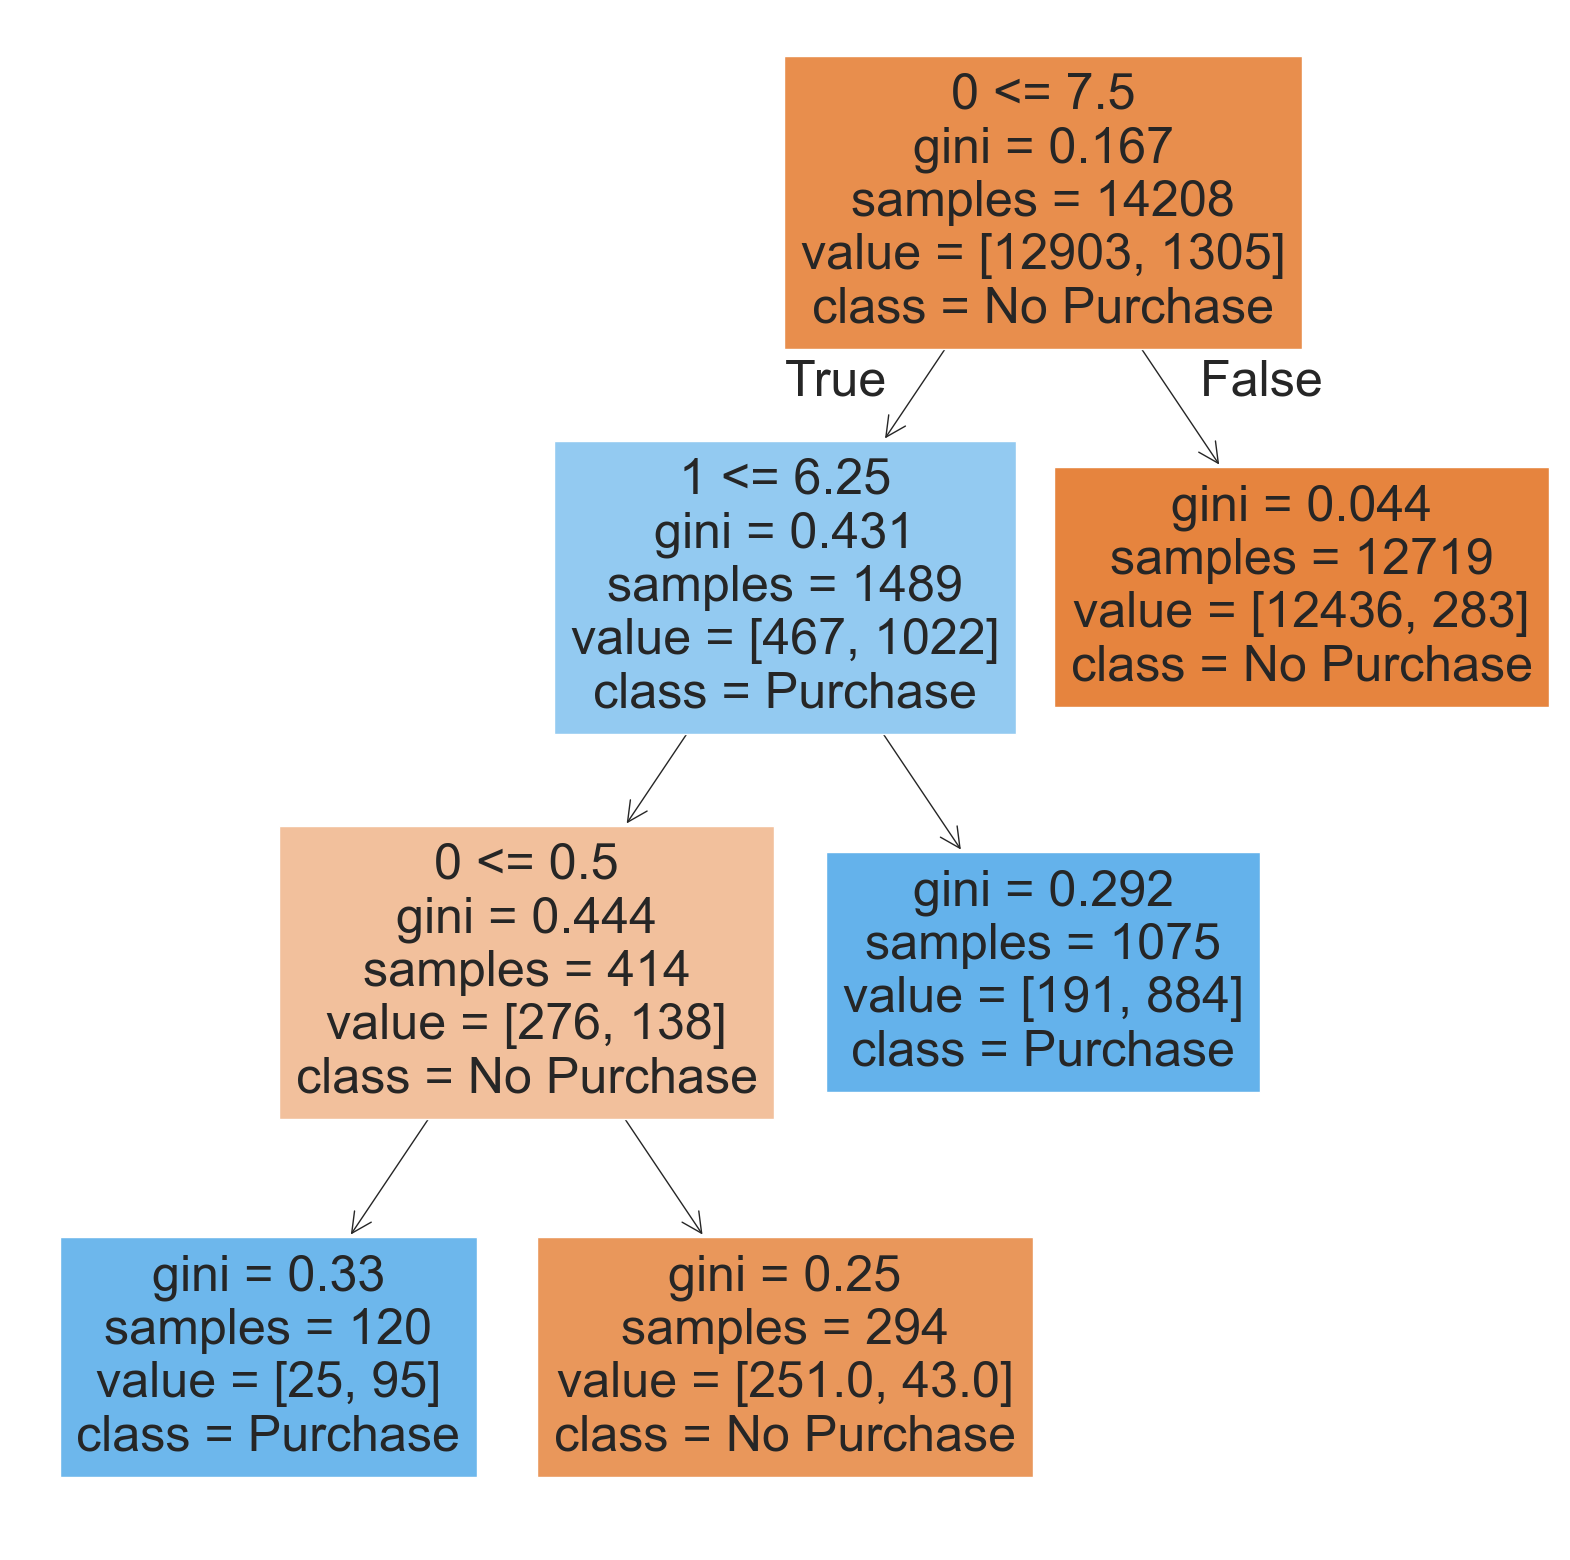

In [55]:
# Set the figure size
plt.figure(figsize=(20, 20))

X_train_array_df = pd.DataFrame(X_train_array)

# Plot the decision tree
plot_tree(best_tree, filled=True, feature_names=X_train_array_df.columns, class_names=['No Purchase', 'Purchase'])

# Show the plot
plt.show()

In [56]:
# Predict on test data
y_test_pred_tree = best_tree.predict(X_test_array)

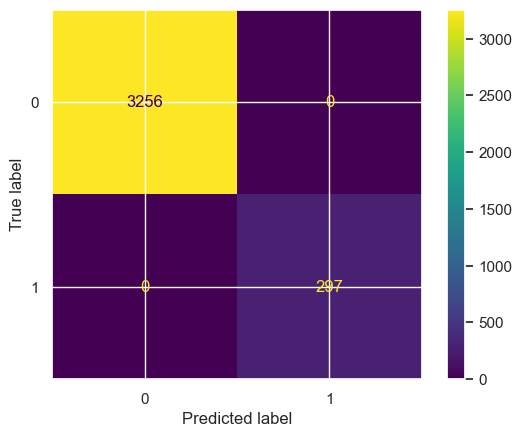

In [59]:
# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(best_tree, X_test_array, y_test_pred_tree)

In [58]:
# Print classification report
print(classification_report(y_test_array, y_test_pred_tree, target_names=['No Purchase', 'Purchase']))

              precision    recall  f1-score   support

 No Purchase       0.97      0.98      0.98      3227
    Purchase       0.82      0.75      0.78       326

    accuracy                           0.96      3553
   macro avg       0.90      0.87      0.88      3553
weighted avg       0.96      0.96      0.96      3553



# Creating a Random Forests Model

In [63]:
# Use the best ccp_alpha value from the Decision Tree model
best_ccp_alpha = 0.003  # Replace with the actual best value found

# Initialize Random Forest Classifier with best ccp_alpha and fixed random state
rf_model = RandomForestClassifier(ccp_alpha=best_ccp_alpha, random_state=365)

In [65]:
# Fit the model on the training data
rf_model.fit(X_train_array, y_train_array)

RandomForestClassifier(ccp_alpha=0.003, random_state=365)

In [66]:
# Make predictions on the test data
y_test_pred_rf = rf_model.predict(X_test_array)

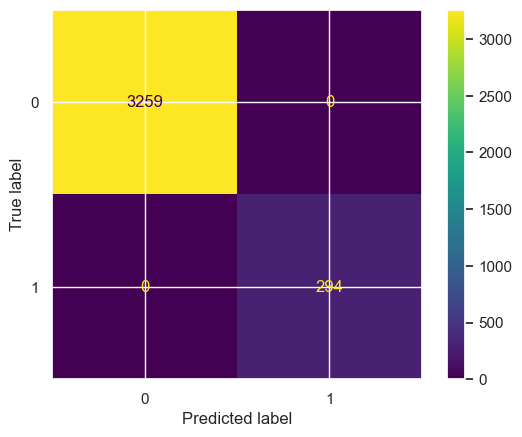

In [67]:
# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(rf_model, X_test_array, y_test_pred_rf)

In [68]:
# Print classification report
print(classification_report(y_test_array, y_test_pred_rf, target_names=['No Purchase', 'Purchase']))

              precision    recall  f1-score   support

 No Purchase       0.97      0.98      0.98      3227
    Purchase       0.83      0.75      0.79       326

    accuracy                           0.96      3553
   macro avg       0.90      0.87      0.88      3553
weighted avg       0.96      0.96      0.96      3553

